In [44]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error 
warnings.filterwarnings('ignore')

ticker_code = "IBM"

df = yf.download(ticker_code, start='2025-01-01', end='2025-06-13', group_by='ticker')
if isinstance(df.columns, pd.MultiIndex): 
    df.columns = df.columns.get_level_values(1)
df.head()

[*********************100%***********************]  1 of 1 completed

Price,Open,High,Low,Close,Volume
Date,,,,,
2025-01-02,218.895348,219.556512,214.730987,217.040131,2579500
2025-01-03,217.642083,220.711079,217.642083,219.714386,3872100
2025-01-06,220.059766,221.391973,217.839432,219.734116,2846700
2025-01-07,220.405183,223.720883,219.892035,221.007141,3299300
2025-01-08,220.957782,221.934719,217.918390,220.237396,2619800


In [45]:
col = df["Close"].diff().dropna()
col

Date
2025-01-03    2.674255
2025-01-06    0.019730
2025-01-07    1.273026
2025-01-08   -0.769745
2025-01-10   -3.384766
                ...   
2025-06-06    2.010010
2025-06-09    3.209991
2025-06-10    4.160004
2025-06-11    5.279999
2025-06-12   -0.489990
Name: Close, Length: 110, dtype: float64

In [46]:
from statsmodels.tsa.stattools import adfuller
res = adfuller(col)
print(res[1] < 0.05)

True


In [47]:
train = col[:-30]
test = col[-30:]

Best Lag: 12, MSE (on original scale): 403.34866213665885


(array([20209., 20216., 20223., 20230., 20240., 20247.]),
 [Text(20209.0, 0, '2025-05-01'),
  Text(20216.0, 0, '2025-05-08'),
  Text(20223.0, 0, '2025-05-15'),
  Text(20230.0, 0, '2025-05-22'),
  Text(20240.0, 0, '2025-06-01'),
  Text(20247.0, 0, '2025-06-08')])

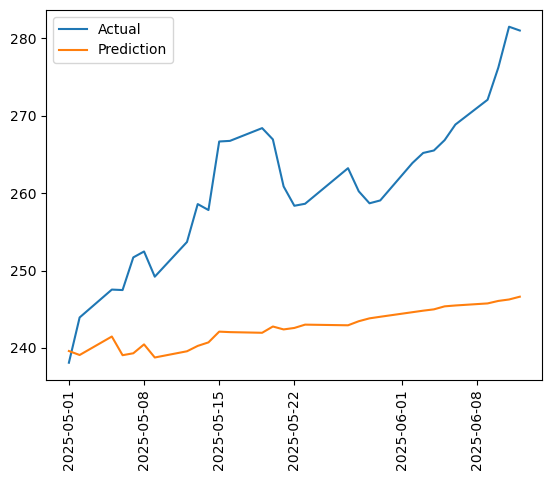

In [48]:
#AR mdoel complete pipeline
from statsmodels.tsa.ar_model import AutoReg

#finding best lag
min_error = float('inf')
best_lag = 1
for lag in range(1,30):
    ar = AutoReg(train , lags = lag)
    ar_fit = ar.fit()
    pred = ar_fit.predict(start = len(train) , end = len(train) + len(test) - 1 , dynamic = False)
    mse = mean_squared_error(pred , test)
    if mse < min_error:
        min_error = mse
        best_lag = lag

#model
ar = AutoReg(train , lags = best_lag).fit()
pred = ar.predict(start = len(train) , end = len(train) + len(test) - 1 , dynamic = False)
mse = mean_squared_error(pred , test)

#invert the differencing
last_real_price = df["Close"].iloc[len(train)]
pred_price = pred.cumsum() + last_real_price

#Evaluate on real price test values
true_test_prices = df["Close"].dropna().iloc[len(train)+1 : len(train)+len(test)+1]
mse = mean_squared_error(true_test_prices, pred_price)
print(f"Best Lag: {best_lag}, MSE (on original scale): {mse}")


#plot
plt.plot(test.index , true_test_prices , label = "Actual")
plt.plot(test.index , pred_price , label = "Prediction")
plt.legend()
plt.xticks(rotation = 90)

Best Order: 2, MSE (on original scale): 325.5720356598773


(array([20209., 20216., 20223., 20230., 20240., 20247.]),
 [Text(20209.0, 0, '2025-05-01'),
  Text(20216.0, 0, '2025-05-08'),
  Text(20223.0, 0, '2025-05-15'),
  Text(20230.0, 0, '2025-05-22'),
  Text(20240.0, 0, '2025-06-01'),
  Text(20247.0, 0, '2025-06-08')])

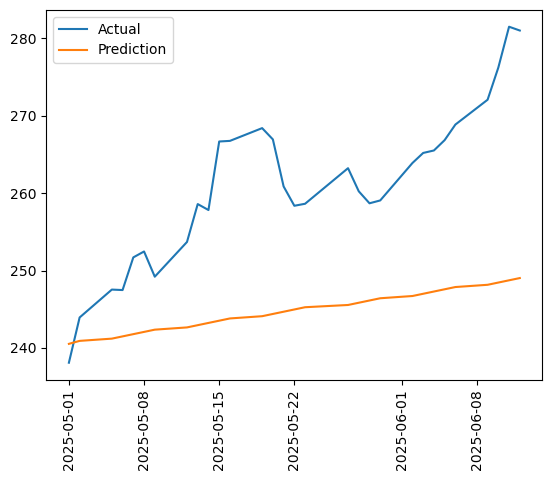

In [49]:
#MA model pipeline but no inbuilt so using ARIMA with p , d = 0 
from statsmodels.tsa.arima.model import ARIMA

#finding best order
min_error = float('inf')
best_order = 1
for order in range(1,3):
    arima = ARIMA(train , order = (0,0,order))
    arima_fit = arima.fit()
    pred = arima_fit.predict(start = len(train) , end = len(train) + len(test) - 1 , dynamic = False)
    mse = mean_squared_error(pred , test)
    if mse < min_error:
        min_error = mse
        best_order = order

#model
arima = ARIMA(train , order = (0,0,best_order))
arima_fit = arima.fit()
pred = arima_fit.predict(start = len(train) , end = len(train) + len(test) - 1 , dynamic = False)

#invert the differencing
last_real_price = df["Close"].iloc[len(train)]
pred_price = pred.cumsum() + last_real_price

#Evaluate on real price test values
true_test_prices = df["Close"].dropna().iloc[len(train)+1 : len(train)+len(test)+1]
mse = mean_squared_error(true_test_prices, pred_price)
print(f"Best Order: {best_order}, MSE (on original scale): {mse}")

#plot
plt.plot(test.index , true_test_prices , label = "Actual")
plt.plot(test.index , pred_price , label = "Prediction")
plt.legend()
plt.xticks(rotation = 90)

(array([20209., 20216., 20223., 20230., 20240., 20247.]),
 [Text(20209.0, 0, '2025-05-01'),
  Text(20216.0, 0, '2025-05-08'),
  Text(20223.0, 0, '2025-05-15'),
  Text(20230.0, 0, '2025-05-22'),
  Text(20240.0, 0, '2025-06-01'),
  Text(20247.0, 0, '2025-06-08')])

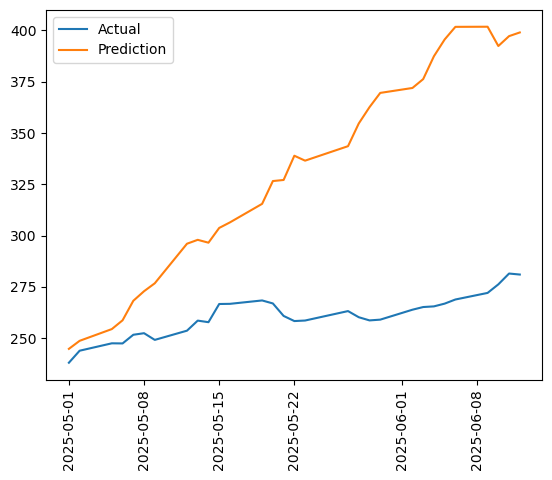

In [51]:
#SARIMA model 
from statsmodels.tsa.statespace.sarimax import SARIMAX
p , d , q , P , D , Q , s =  7 , 1 , 7 , 1 , 1 , 1 , 45
sarimax = SARIMAX(train , order = (p,d,q) , seasonal_order = (P,D,Q,s))
sarimax_fit = sarimax.fit()
pred = sarimax_fit.predict(
    start = len(train),
    end = len(train) + len(test) - 1,
    dynamic = False
)
last_real_price = df["Close"].iloc[len(train)]
pred_price = pred.cumsum() + last_real_price
true_test_prices = df["Close"].dropna().iloc[len(train)+1 : len(train)+len(test)+1]
mse = mean_squared_error(true_test_prices, pred_price)
plt.plot(test.index , true_test_prices , label = "Actual")
plt.plot(test.index , pred_price , label = "Prediction")
plt.legend()
plt.xticks(rotation = 90)